<a href="https://colab.research.google.com/github/trefftzc/cis677/blob/main/numba_cuda_tutorial_by_carlos_costa_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CUDA Tutorial by Carlos Costa - Streams and Events

This tutorial is based on this web page:

https://towardsdatascience.com/cuda-by-numba-examples-7652412af1ee/

n the first two installments of this series (part 1 here, and part 2 here), we learned how to perform simple tasks with GPU programming, such as embarrassingly parallel tasks, reductions using shared memory, and device functions. We also learned how to time functions from the host – and why that might not be the best way to time code.

In [ ]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

The environment variables NUMBAPRO_LIBDEVICE and NUMBAPRO_NVM must match the most recent version installed on COLAB.

In [5]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-12.5/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-12.5/nvvm/lib64/libnvvm.so"


In [6]:
!uv pip install -q --system numba-cuda==0.15


In [10]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [11]:
import warnings
from time import perf_counter, sleep

import numpy as np

import numba
from numba import cuda
from numba.core.errors import NumbaPerformanceWarning

print(np.__version__)
print(numba.__version__)

# Ignore NumbaPerformanceWarning
warnings.simplefilter("ignore", category=NumbaPerformanceWarning)


2.0.2
0.60.0


# Streams

When we launch a kernel from the host, its execution is queued in the GPU, to be done whenever the GPU has done all tasks launched previously.

Many tasks that the user launches in the device may depend on previous tasks, and "putting them in the same queue" makes sense. For example, if you are copying data asynchronously to the GPU to process it with a certain kernel, that copy must have finalized before the kernel runs.

But what if you have two kernels that are independent of each other, would it make sense to put them in the same queue? Probably not! For these cases, CUDA has streams. You can think of streams as separate queues, which run independently of each other. They can also run concurrently, that is, at the same time. This can vastly speed up total runtime when running many independent tasks.

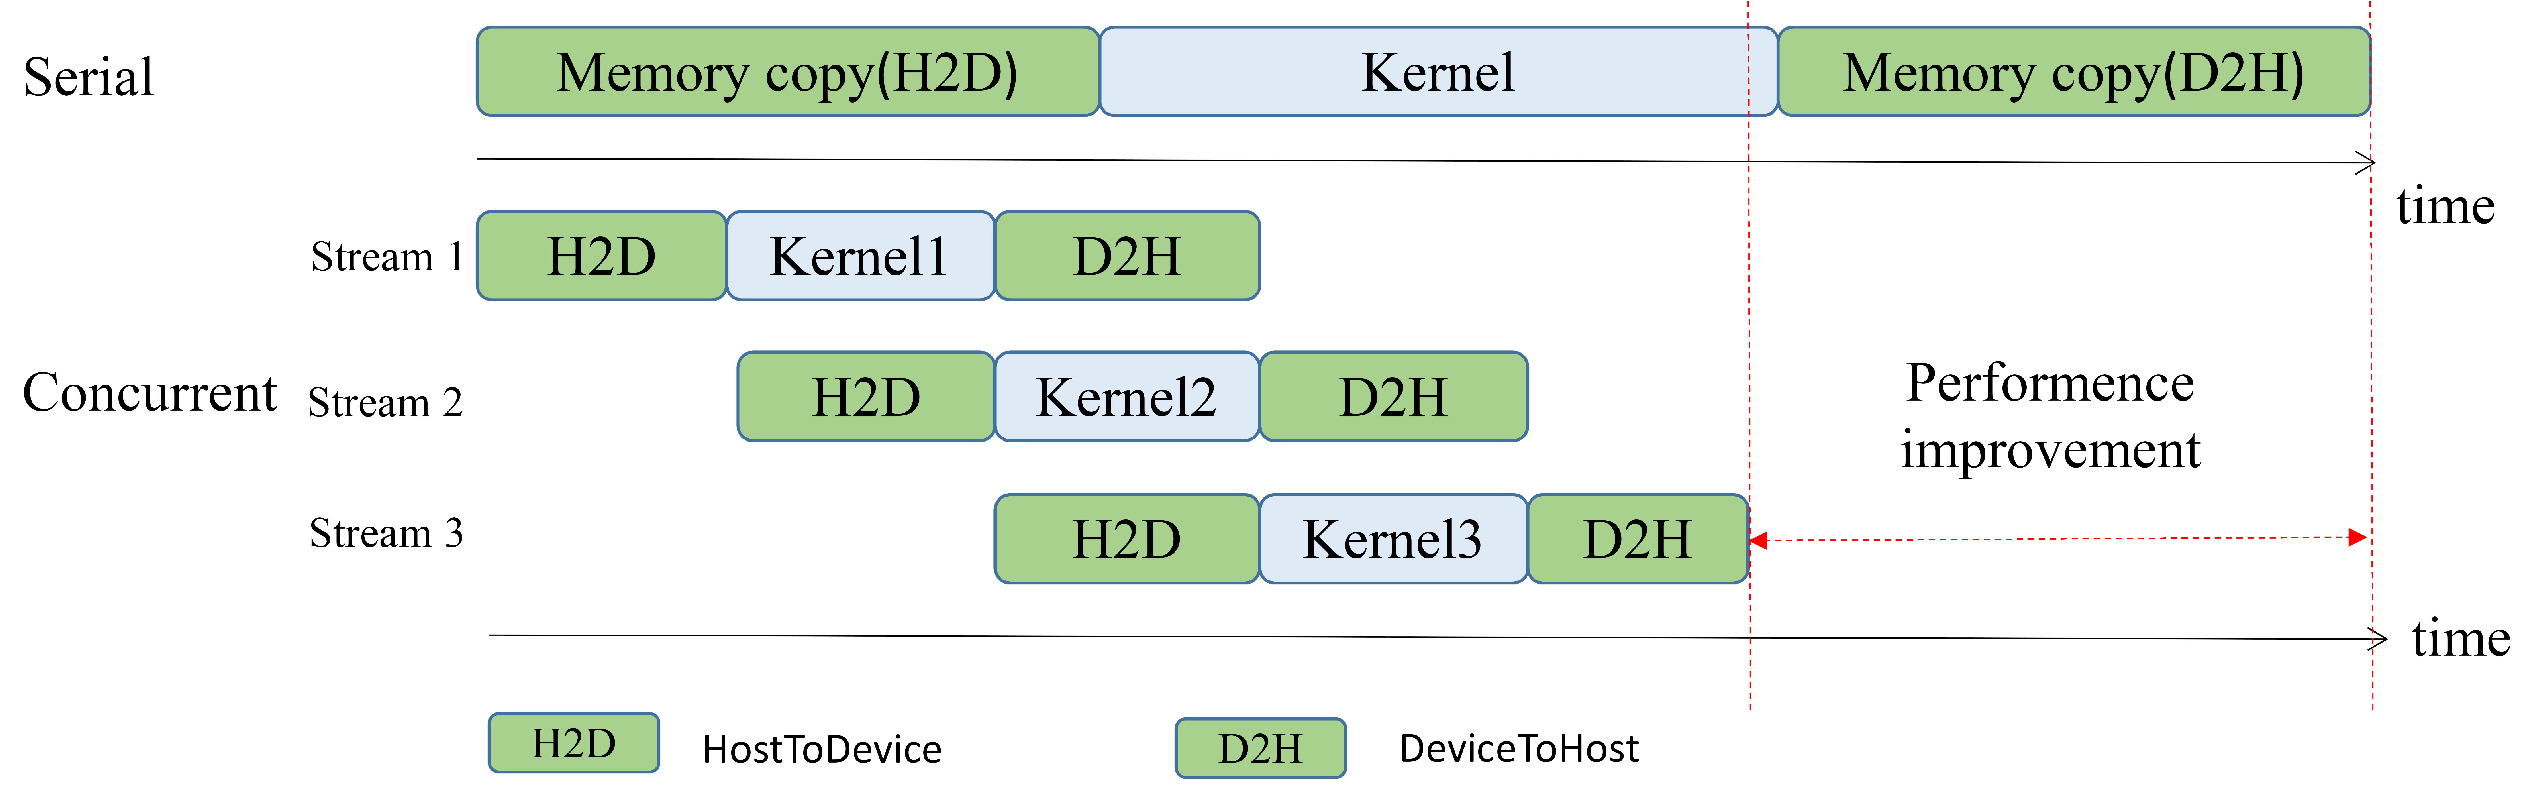

# Stream Semantics in Numba CUDA

We will take the two tasks we learned so far and queue them to create a normalization pipeline. Given a (host) array a, we will overwrite it with a normalized version of it:

a ← a / ∑a[i]

For that we will use three kernels. The first kernel partial_reduce will be our partial reduction from Part 2. It will return a threads_per_block-sized array, which we will pass to another kernel, single_thread_sum which will further reduce that to a singleton array (size 1). This kernel will be run on a single block with a single thread. Finally, we will use divide_by to divide in-place out original array but the sum we previously calculated. All of these operations will take place in the GPU, and should run one after the other.

In [12]:
threads_per_block = 256
blocks_per_grid = 32 * 40

@cuda.jit
def partial_reduce(array, partial_reduction):
    i_start = cuda.grid(1)
    threads_per_grid = cuda.blockDim.x * cuda.gridDim.x
    s_thread = 0.0
    for i_arr in range(i_start, array.size, threads_per_grid):
        s_thread += array[i_arr]

    s_block = cuda.shared.array((threads_per_block,), numba.float32)
    tid = cuda.threadIdx.x
    s_block[tid] = s_thread
    cuda.syncthreads()

    i = cuda.blockDim.x // 2
    while (i > 0):
        if (tid < i):
            s_block[tid] += s_block[tid + i]
        cuda.syncthreads()
        i //= 2

    if tid == 0:
        partial_reduction[cuda.blockIdx.x] = s_block[0]

@cuda.jit
def single_thread_sum(partial_reduction, sum):
    sum[0] = 0.0
    for element in partial_reduction:
        sum[0] += element


@cuda.jit
def divide_by(array, val_array):
    i_start = cuda.grid(1)
    threads_per_grid = cuda.gridsize(1)
    for i in range(i_start, array.size, threads_per_grid):
        array[i] /= val_array[0]

When kernel calls and other operations are not given a stream, they run in the default stream. The default stream is a special stream whose behavior depends on whether one is running legacy or per-thread streams.

 For us, it will suffice to say that if you want to achieve concurrency, you should run tasks in non-default streams. Let’s see how to do that for some operations such as kernel launch, array copy and array creation copy.

In [13]:
# Define host array
a = np.ones(10_000_000, dtype=np.float32)
print(f"Old sum: {a.sum():.2f}")
# Old sum: 10000000.00

# Example 3.1: Numba CUDA Stream Semantics

# Pin memory
with cuda.pinned(a):
    # Create a CUDA stream
    stream = cuda.stream()

    # Array copy to device and creation in the device. With Numba, you pass the
    # stream as an additional to API functions.
    dev_a = cuda.to_device(a, stream=stream)
    dev_a_reduce = cuda.device_array((blocks_per_grid,), dtype=dev_a.dtype, stream=stream)
    dev_a_sum = cuda.device_array((1,), dtype=dev_a.dtype, stream=stream)

    # When launching kernels, stream is passed to the kernel launcher ("dispatcher")
    # configuration, and it comes after the block dimension (`threads_per_block`)
    partial_reduce[blocks_per_grid, threads_per_block, stream](dev_a, dev_a_reduce)
    single_thread_sum[1, 1, stream](dev_a_reduce, dev_a_sum)
    divide_by[blocks_per_grid, threads_per_block, stream](dev_a, dev_a_sum)

    # Array copy to host: like the copy to device, when a stream is passed, the copy
    # is asynchronous. Note: the printed output will probably be nonsensical since
    # the write has not been synchronized yet.
    dev_a.copy_to_host(a, stream=stream)

# Whenever we want to ensure that all operations in a stream are finished from
# the point of view of the host, we call:
stream.synchronize()

# After that call, we can be sure that `a` has been overwritten with its
# normalized version
print(f"New sum: {a.sum():.2f}")

Old sum: 10000000.00
New sum: 1.00


Before we can actually talk about streams, we need to talk about the elephant in the room: cuda.pinned. This context manager creates a special type of memory called page-locked or pinned memory, which CUDA will benefit when transferring memory from host to device.
Memory sitting in the host RAM can be _paged_ at any moment, that is, the operating system can surreptitiously move objects from RAM to hard disk. They do this so that objects used infrequently are moved to a slower memory location, leaving the fast RAM memory available for more urgently needed objects.

What matters to us is that CUDA does not allow asynchronous transfers from pageable objects to the GPU. It does this to prevent a constant stream of very slow transfers: disk (paged) → RAM → GPU.
To transfer data asynchronously, we must then ensure that the data always sits in RAM by somehow preventing the OS from sneakily hiding it in the disk somewhere. This is where the memory pinning comes into play, it creates a context within which the argument will be "page-locked", that is, forced to be in RAM. See Figure 3.2.

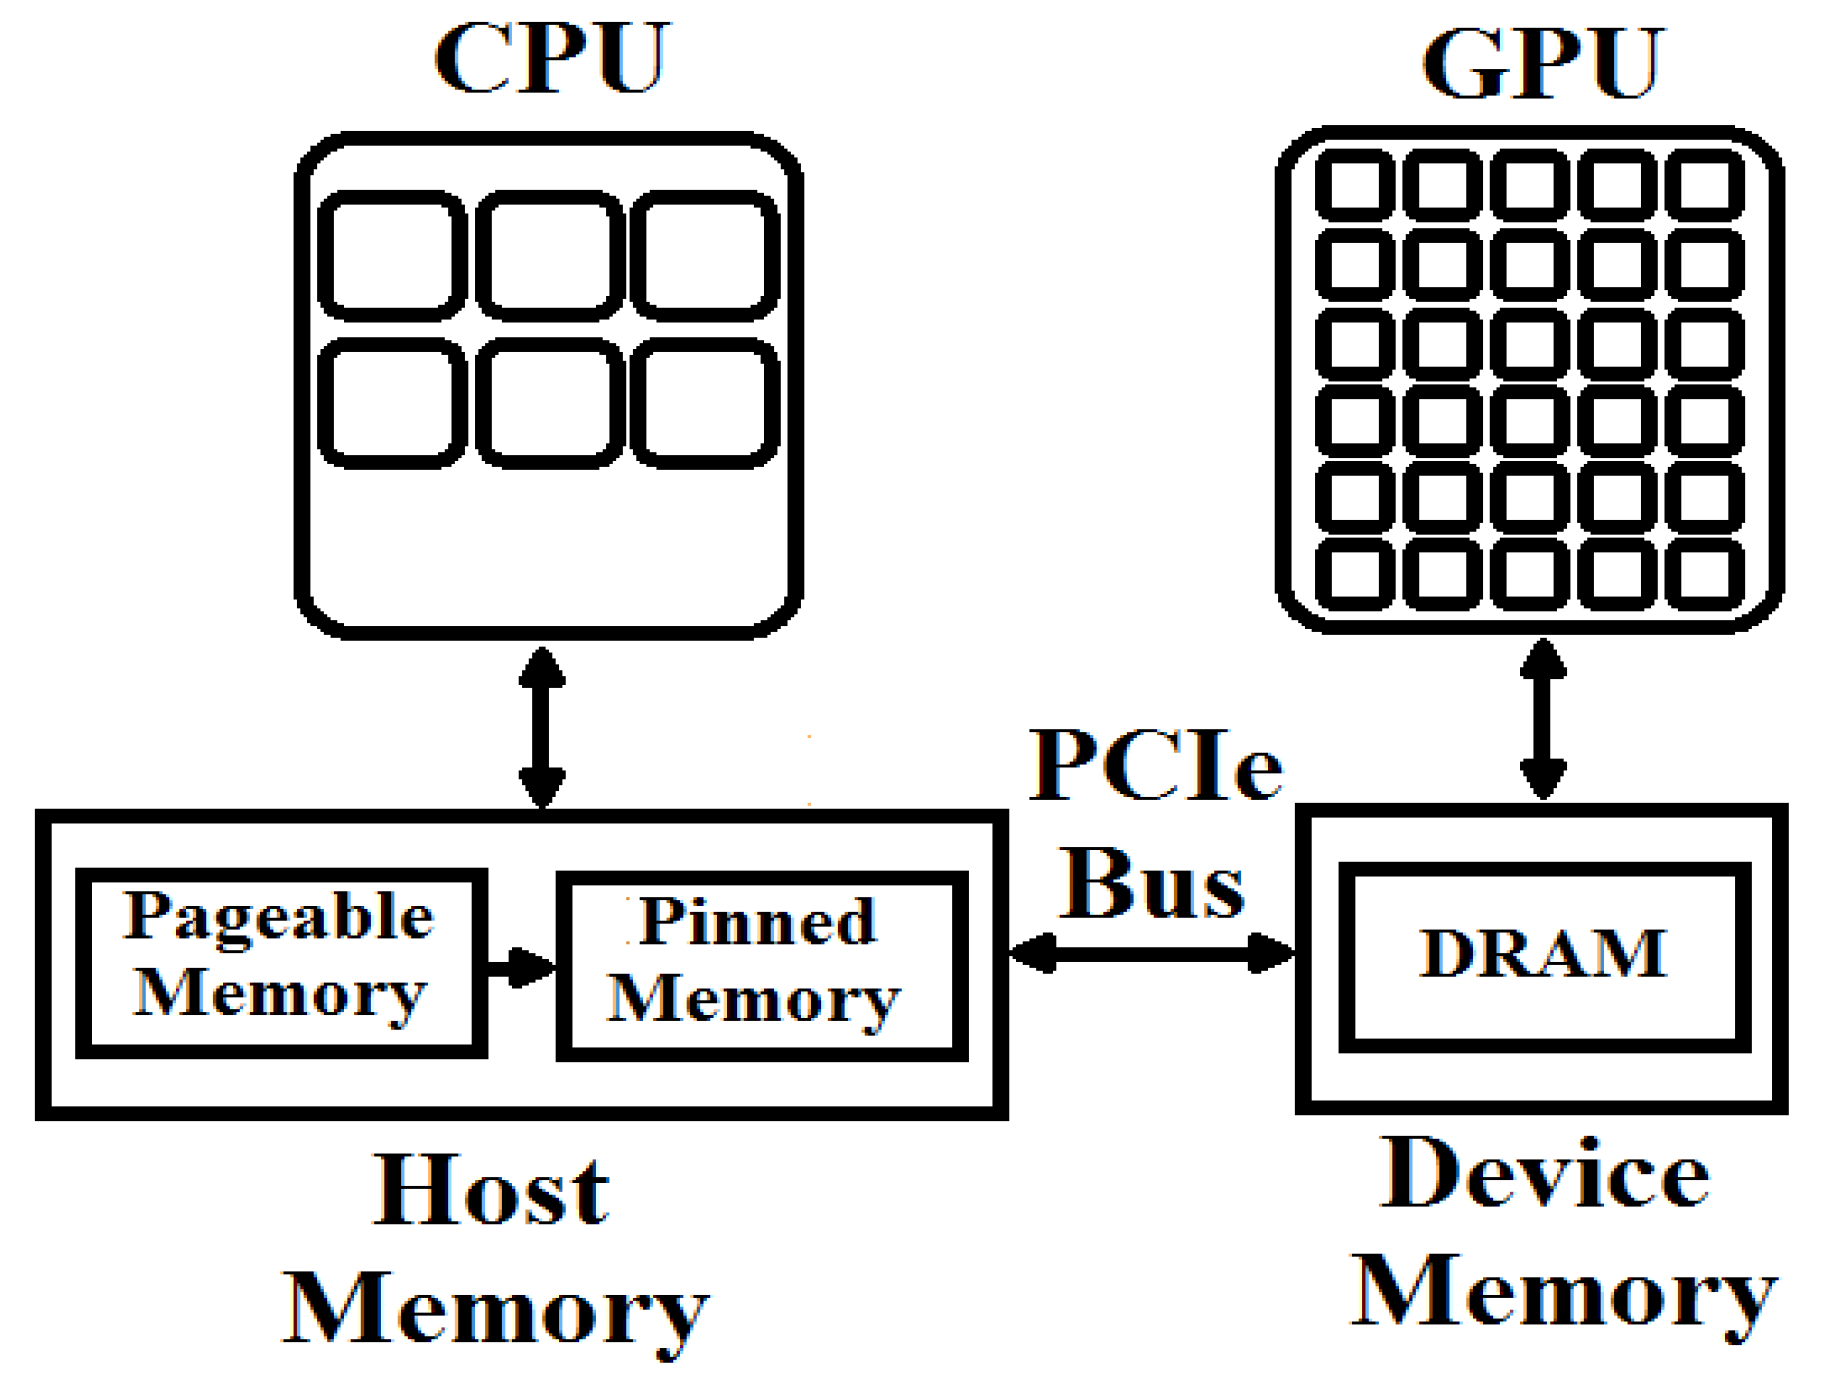

From then on, the code is pretty straight forward. A stream is created, after which it will be passed to every CUDA function that we want to operate on that stream. Importantly, the Numba CUDA kernel configuration (square brackets) requires the stream to be in the third argument, after the block dimension size.

_WARNING: Generally, passing a stream to a Numba CUDA API function does not change its behavior, only the stream in which it runs. One exception is the copy from device to host. When calling device_array.copy_to_host() (without arguments), the copy happens synchronously. When calling device_array.copy_to_host(stream=stream) (with a stream), the copy will happen synchronously if device_array is not pinned. The copy will only happen asynchronously if device_array is pinned and a stream is passed._

INFO: Numba provides a useful context manager, to enqueue all operations within its context; when exiting the context, operations will be synced, including memory transfers. Example 3.1 can also be written as:


# cDecoupling Independent Kernels with Streams

Suppose we want to make normalize not one array, but multiple arrays. The operations for normalization of separate arrays are completely independent of each other. Therefore, it doesn’t make sense for the GPU to wait until one normalization ends before the next one begins. We should therefore separate these tasks into their separate streams.

Let’s see an example of normalizing 10 arrays – each using its own stream.

In [14]:
N_streams = 10
# Do not memory-collect (deallocate arrays) within this context
with cuda.defer_cleanup():
    # Create 10 streams
    streams = [cuda.stream() for _ in range(1, N_streams + 1)]

    # Create base arrays
    arrays = [
        i * np.ones(10_000_000, dtype=np.float32) for i in range(1, N_streams + 1)
    ]

    for i, arr in enumerate(arrays):
        print(f"Old sum (array {i}): {arr.sum():12.2f}")

    tics = []  # Launch start times
    for i, (stream, arr) in enumerate(zip(streams, arrays)):
        tic = perf_counter()
        with cuda.pinned(arr):
            dev_a = cuda.to_device(arr, stream=stream)
            dev_a_reduce = cuda.device_array(
                (blocks_per_grid,), dtype=dev_a.dtype, stream=stream
            )
            dev_a_sum = cuda.device_array((1,), dtype=dev_a.dtype, stream=stream)

            partial_reduce[blocks_per_grid, threads_per_block, stream](dev_a, dev_a_reduce)
            single_thread_sum[1, 1, stream](dev_a_reduce, dev_a_sum)
            divide_by[blocks_per_grid, threads_per_block, stream](dev_a, dev_a_sum)

            dev_a.copy_to_host(arr, stream=stream)

        toc = perf_counter()  # Stop time of launches
        print(f"Launched processing {i} in {1e3 * (toc - tic):.2f} ms")

        # Ensure that the reference to the GPU arrays are deleted, this will
        # ensure garbage collection at the exit of the context.
        del dev_a, dev_a_reduce, dev_a_sum

        tics.append(tic)

    tocs = []
    for i, (stream, arr) in enumerate(zip(streams, arrays)):
        stream.synchronize()
        toc = perf_counter()  # Stop time of sync
        tocs.append(toc)
        print(f"New sum (array {i}): {arr.sum():12.2f}")
    for i in range(4):
        print(f"Performed processing {i} in {1e3 * (tocs[i] - tics[i]):.2f} ms")

    print(f"Total time {1e3 * (tocs[-1] - tics[0]):.2f} ms")

Old sum (array 0):  10000000.00
Old sum (array 1):  20000000.00
Old sum (array 2):  30000000.00
Old sum (array 3):  40000000.00
Old sum (array 4):  50000000.00
Old sum (array 5):  60000000.00
Old sum (array 6):  70000000.00
Old sum (array 7):  80000000.00
Old sum (array 8):  90000000.00
Old sum (array 9): 100000000.00
Launched processing 0 in 12.87 ms
Launched processing 1 in 11.15 ms
Launched processing 2 in 10.95 ms
Launched processing 3 in 10.84 ms
Launched processing 4 in 10.84 ms
Launched processing 5 in 10.96 ms
Launched processing 6 in 10.93 ms
Launched processing 7 in 10.82 ms
Launched processing 8 in 10.98 ms
Launched processing 9 in 11.20 ms
New sum (array 0):         1.00
New sum (array 1):         1.00
New sum (array 2):         1.00
New sum (array 3):         1.00
New sum (array 4):         1.00
New sum (array 5):         1.00
New sum (array 6):         1.00
New sum (array 7):         1.00
New sum (array 8):         1.00
New sum (array 9):         1.00
Performed processing

And now let’s compare to a single stream.

In [15]:
# Example 3.3: Single stream

# Do not memory-collect (deallocate arrays) within this context
with cuda.defer_cleanup():
    # Create 1 streams
    streams = [cuda.stream()] * N_streams

    # Create base arrays
    arrays = [
        i * np.ones(10_000_000, dtype=np.float32) for i in range(1, N_streams + 1)
    ]

    for i, arr in enumerate(arrays):
        print(f"Old sum (array {i}): {arr.sum():12.2f}")

    tics = []  # Launch start times
    for i, (stream, arr) in enumerate(zip(streams, arrays)):
        tic = perf_counter()

        with cuda.pinned(arr):
            dev_a = cuda.to_device(arr, stream=stream)
            dev_a_reduce = cuda.device_array(
                (blocks_per_grid,), dtype=dev_a.dtype, stream=stream
            )
            dev_a_sum = cuda.device_array((1,), dtype=dev_a.dtype, stream=stream)

            partial_reduce[blocks_per_grid, threads_per_block, stream](dev_a, dev_a_reduce)
            single_thread_sum[1, 1, stream](dev_a_reduce, dev_a_sum)
            divide_by[blocks_per_grid, threads_per_block, stream](dev_a, dev_a_sum)

            dev_a.copy_to_host(arr, stream=stream)

        toc = perf_counter()  # Stop time of launches
        print(f"Launched processing {i} in {1e3 * (toc - tic):.2f} ms")

        # Ensure that the reference to the GPU arrays are deleted, this will
        # ensure garbage collection at the exit of the context.
        del dev_a, dev_a_reduce, dev_a_sum

        tics.append(tic)

    tocs = []
    for i, (stream, arr) in enumerate(zip(streams, arrays)):
        stream.synchronize()
        toc = perf_counter()  # Stop time of sync
        tocs.append(toc)
        print(f"New sum (array {i}): {arr.sum():12.2f}")
    for i in range(4):
        print(f"Performed processing {i} in {1e3 * (tocs[i] - tics[i]):.2f} ms")

    print(f"Total time {1e3 * (tocs[-1] - tics[0]):.2f} ms")

Old sum (array 0):  10000000.00
Old sum (array 1):  20000000.00
Old sum (array 2):  30000000.00
Old sum (array 3):  40000000.00
Old sum (array 4):  50000000.00
Old sum (array 5):  60000000.00
Old sum (array 6):  70000000.00
Old sum (array 7):  80000000.00
Old sum (array 8):  90000000.00
Old sum (array 9): 100000000.00
Launched processing 0 in 11.78 ms
Launched processing 1 in 11.38 ms
Launched processing 2 in 11.17 ms
Launched processing 3 in 11.06 ms
Launched processing 4 in 11.07 ms
Launched processing 5 in 11.15 ms
Launched processing 6 in 11.02 ms
Launched processing 7 in 10.99 ms
Launched processing 8 in 10.91 ms
Launched processing 9 in 10.97 ms
New sum (array 0):         1.00
New sum (array 1):         1.00
New sum (array 2):         1.00
New sum (array 3):         1.00
New sum (array 4):         1.00
New sum (array 5):         1.00
New sum (array 6):         1.00
New sum (array 7):         1.00
New sum (array 8):         1.00
New sum (array 9):         1.00
Performed processing

But which one is faster? When running these examples, I do not get a consistent improvement for total time when using multiple streams. There can be many reasons for this. For example, for streams to run concurrently, there must be enough space in local memory. In addition, we are timing from the CPU. While it can very hard to know if there is enough space in local memory, timing from the GPU is relatively easy. Let’s learn how!

# Events

One of the issues with timing code from the CPU is that it will include many more operations other than that of the GPU.

Thankfully, it is possible to time directly from the GPU with CUDA events. An event is simply a time register of when something happened in the GPU. In a way it is similar to time.time and time.perf_counter, differently from those, we need to deal with the fact that while we are programming from the CPU, we want to time events from the GPU.

So, beyond instead of just creating timestamps ("recording" events), we need to ensure that events are synchronized with the CPU before we can access its values. Let us examine a simple example.

In [16]:
# Example 3.4: Simple events

# Events need to be initialized, but this does not starting timing.
# We create two events, one at the start of computations, and one at the end.
event_beg = cuda.event()
event_end = cuda.event()

# Create CUDA stream
stream = cuda.stream()

with cuda.pinned(arr):
    # Queue array copy/create in `stream`
    dev_a = cuda.to_device(arr, stream=stream)
    dev_a_reduce = cuda.device_array((blocks_per_grid,), dtype=dev_a.dtype, stream=stream)

    # Here we issue our first event recording. `event_beg` from this line onwards
    # will contain the time referring to this moment in the GPU.
    event_beg.record(stream=stream)

    # Launch kernel asynchronously
    partial_reduce[blocks_per_grid, threads_per_block, stream](dev_a, dev_a_reduce)

    # Launch a "record" which will be trigged when the kernel run ends
    event_end.record(stream=stream)

    # Future tasks submitted to the stream will wait util `event_end` completes.
    event_end.wait(stream=stream)

    # Synchronize this event with the CPU, so we can use its value.
    event_end.synchronize()

# Now we calculate the time it took to execute the kernel. Note that we do not
# need to wait/synchronize `event_beg` because its execution is contingent upon
# event_end having waited/synchronized
timing_ms = event_beg.elapsed_time(event_end)  # in miliseconds

print(f"Elapsed time {timing_ms:.2f} ms")
# Elapsed time 0.57 ms

Elapsed time 0.51 ms


One useful recipe for timing GPU operations is by using context managers:

In [17]:
# Example 3.5: Context Manager for CUDA Timer using Events
class CUDATimer:
    def __init__(self, stream):
        self.stream = stream
        self.event = None  # in ms

    def __enter__(self):
        self.event_beg = cuda.event()
        self.event_end = cuda.event()
        self.event_beg.record(stream=self.stream)
        return self

    def __exit__(self, type, value, traceback):
        self.event_end.record(stream=self.stream)
        self.event_end.wait(stream=self.stream)
        self.event_end.synchronize()
        self.elapsed = self.event_beg.elapsed_time(self.event_end)


stream = cuda.stream()
dev_a = cuda.to_device(arrays[0], stream=stream)
dev_a_reduce = cuda.device_array((blocks_per_grid,), dtype=dev_a.dtype, stream=stream)
with CUDATimer(stream) as cudatimer:
    partial_reduce[blocks_per_grid, threads_per_block, stream](dev_a, dev_a_reduce)
print(f"Elapsed time {cudatimer.elapsed:.2f} ms")
# Elapsed time 0.53 ms

Elapsed time 0.52 ms


# Events for Timing Streams

To end this installment of the series, we will use streams to get a better, more accurate view of whether our example is benefiting from streams of not.

In [18]:
# Example 3.6: Timing a single streams with events

N_streams = 10

# Do not memory-collect (deallocate arrays) within this context
with cuda.defer_cleanup():
    # Create 1 stream
    streams = [cuda.stream()] * N_streams

    # Create base arrays
    arrays = [
        i * np.ones(10_000_000, dtype=np.float32) for i in range(1, N_streams + 1)
    ]

    events_beg = []  # Launch start times
    events_end = []  # End start times
    for i, (stream, arr) in enumerate(zip(streams, arrays)):
        with cuda.pinned(arr):
            # Declare events and record start
            event_beg = cuda.event()
            event_end = cuda.event()
            event_beg.record(stream=stream)

            # Do all CUDA operations
            dev_a = cuda.to_device(arr, stream=stream)
            dev_a_reduce = cuda.device_array(
                (blocks_per_grid,), dtype=dev_a.dtype, stream=stream
            )
            dev_a_sum = cuda.device_array((1,), dtype=dev_a.dtype, stream=stream)
            partial_reduce[blocks_per_grid, threads_per_block, stream](dev_a, dev_a_reduce)
            single_thread_sum[1, 1, stream](dev_a_reduce, dev_a_sum)
            divide_by[blocks_per_grid, threads_per_block, stream](dev_a, dev_a_sum)
            dev_a.copy_to_host(arr, stream=stream)

            # Record end
            event_end.record(stream=stream)

        events_beg.append(event_beg)
        events_end.append(event_end)

        del dev_a, dev_a_reduce, dev_a_sum

sleep(5)  # Wait for all events to finish, does not affect GPU timing
for event_end in events_end:
    event_end.synchronize()

# The first `event_beg` launched is the earliest event. But the last `event_end`
# is not known a priori. We find which event that is with:
elapsed_times = [events_beg[0].elapsed_time(event_end) for event_end in events_end]
i_stream_last = np.argmax(elapsed_times)

print(f"Last stream: {i_stream_last}")
print(f"Total time {elapsed_times[i_stream_last]:.2f} ms")
# Last stream: 9
# Total time 113.16 ms

# Example 3.7: Timing multiple streams with events

# Do not memory-collect (deallocate arrays) within this context
with cuda.defer_cleanup():
    # Create 10 streams
    streams = [cuda.stream() for _ in range(1, N_streams + 1)]

    # Create base arrays
    arrays = [
        i * np.ones(10_000_000, dtype=np.float32) for i in range(1, N_streams + 1)
    ]

    events_beg = []  # Launch start times
    events_end = []  # End start times
    for i, (stream, arr) in enumerate(zip(streams, arrays)):
        with cuda.pinned(arr):
            # Declare events and record start
            event_beg = cuda.event()
            event_end = cuda.event()
            event_beg.record(stream=stream)

            # Do all CUDA operations
            dev_a = cuda.to_device(arr, stream=stream)
            dev_a_reduce = cuda.device_array(
                (blocks_per_grid,), dtype=dev_a.dtype, stream=stream
            )
            dev_a_sum = cuda.device_array((1,), dtype=dev_a.dtype, stream=stream)
            partial_reduce[blocks_per_grid, threads_per_block, stream](dev_a, dev_a_reduce)
            single_thread_sum[1, 1, stream](dev_a_reduce, dev_a_sum)
            divide_by[blocks_per_grid, threads_per_block, stream](dev_a, dev_a_sum)
            dev_a.copy_to_host(arr, stream=stream)

            # Record end
            event_end.record(stream=stream)

        events_beg.append(event_beg)
        events_end.append(event_end)

        del dev_a, dev_a_reduce, dev_a_sum

sleep(5)  # Wait for all events to finish, does not affect GPU timing
for event_end in events_end:
    event_end.synchronize()

# The first `event_beg` launched is the earliest event. But the last `event_end`
# is not known a priori. We find which event that is with:
elapsed_times = [events_beg[0].elapsed_time(event_end) for event_end in events_end]
i_stream_last = np.argmax(elapsed_times)

print(f"Last stream: {i_stream_last}")
print(f"Total time {elapsed_times[i_stream_last]:.2f} ms")
# Last stream: 9
# Total time 108.50 ms

Last stream: 9
Total time 108.88 ms
Last stream: 9
Total time 110.09 ms


# Conclusion

CUDA is all about performance. In this tutorial you learned how to accurately measure execution time of kernels using events, in a way that can be used to profile your code. You also learned about streams and how they can be used to always keep your GPUs busy, as well as pinned or mapped arrays, and how they can improve memory access.